In [31]:
# install packages
import sys
!{sys.executable} -m pip install networkx
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install numpy

You are using pip version 9.0.1, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 21.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [35]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

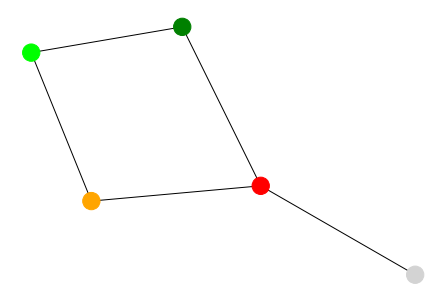

In [30]:

  
g = nx.Graph()
  
g.add_edge(1, 2)
g.add_edge(2, 3)
g.add_edge(3, 4)
g.add_edge(1, 4)
g.add_edge(1, 5)
pos=nx.get_node_attributes(g,'pos')
labels = nx.get_edge_attributes(g,'weight')

nx.draw(g, node_color = ["red","orange","lime","green","lightgray"])

In [139]:
vertex_limit = 300
poisson_param = 3
p = 0.25


adjacency_dict = {1 : []}
count = 1
curr_vertex = 1
colors = ["orange"]
sizes = [100]
vertex_color = {1: "lime", 0: "lightgray"}
vertex_size = {1: 100, 0: 25}
layer = 1

while (count < vertex_limit):
    
    num_neighbors = np.random.poisson(lam=max(1,poisson_param - curr_vertex + 1)) + 1
    for neighbor in range(num_neighbors):
        count += 1
        vertex_list.append(count)
        adjacency_dict[curr_vertex].append(count)
        adjacency_dict[count] = []
        
#         success = np.random.binomial(1, p**(max(1,5 - layer)))
        success = np.random.binomial(1, p**layer)
        colors.append(vertex_color[success])
        sizes.append(vertex_size[success])
    curr_vertex += 1
    if curr_vertex not in adjacency_dict[layer]:
        layer += 1


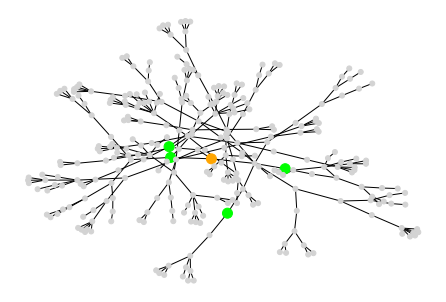

In [140]:
g = nx.Graph()
for v1, val in adjacency_dict.items():
    for v2 in val:
        g.add_edge(v1,v2,)
nx.draw(g, node_color = colors,node_size=sizes)

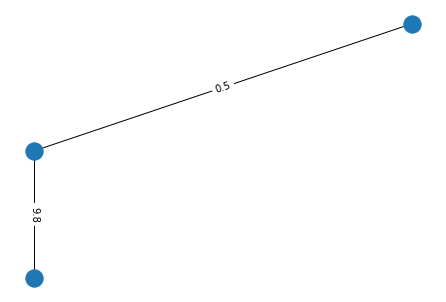

In [22]:
G=nx.Graph()
i=1
G.add_node(i,pos=(i,i))
G.add_node(2,pos=(2,2))
G.add_node(3,pos=(1,0))
G.add_edge(1,2,weight=0.5)
G.add_edge(1,3,weight=9.8)
pos=nx.get_node_attributes(G,'pos')
nx.draw(G,pos)
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
plt.show()
